In [2]:
DATA = "./DATA/"
META_DATA = f"{DATA}images.csv/"
IMAGES = f"{DATA}images_compressed/"

hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

### Clean Corrupt Images

In [39]:
import os
from PIL import Image
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def is_image_corrupt(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError, Image.UnidentifiedImageError):
        return True

def find_corrupt_images(folder_path):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    num_cores = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        results = executor.map(is_image_corrupt, image_files)
    
    corrupt_images = [img for img, is_corrupt in zip(image_files, results) if is_corrupt]
    return corrupt_images


folder_path = IMAGES  # Replace with your folder path
corrupt_images = find_corrupt_images(folder_path)

print("Corrupt images:")
for img in corrupt_images:
    print(img)
print(f"Total corrupt images found: {len(corrupt_images)}")

Corrupt images:
./DATA/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
./DATA/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
./DATA/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
./DATA/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
./DATA/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
./DATA/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
Total corrupt images found: 6


In [40]:
corrupt_images

['./DATA/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
 './DATA/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg',
 './DATA/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
 './DATA/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
 './DATA/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
 './DATA/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg']

In [44]:
df = pd.read_csv("./DATA/images.csv")
df

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PIL_Image
import torch
from transformers import MllamaForConditionalGeneration, MllamaProcessor

In [20]:
df = pd.read_csv("./DATA/images.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


In [22]:
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [23]:
# Step 4: Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
image        0
sender_id    0
label        0
kids         0
dtype: int64


In [24]:
print("\nUnique labels:")
print(df['label'].nunique())
print("\n Label Distribution:")
print(df['label'].value_counts())


Unique labels:
20

 Label Distribution:
label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64


In [25]:
print("\nDistribution of kids vs. non-kids images:")
print(df['kids'].value_counts(normalize=True))


Distribution of kids vs. non-kids images:
kids
False    0.911901
True     0.088099
Name: proportion, dtype: float64


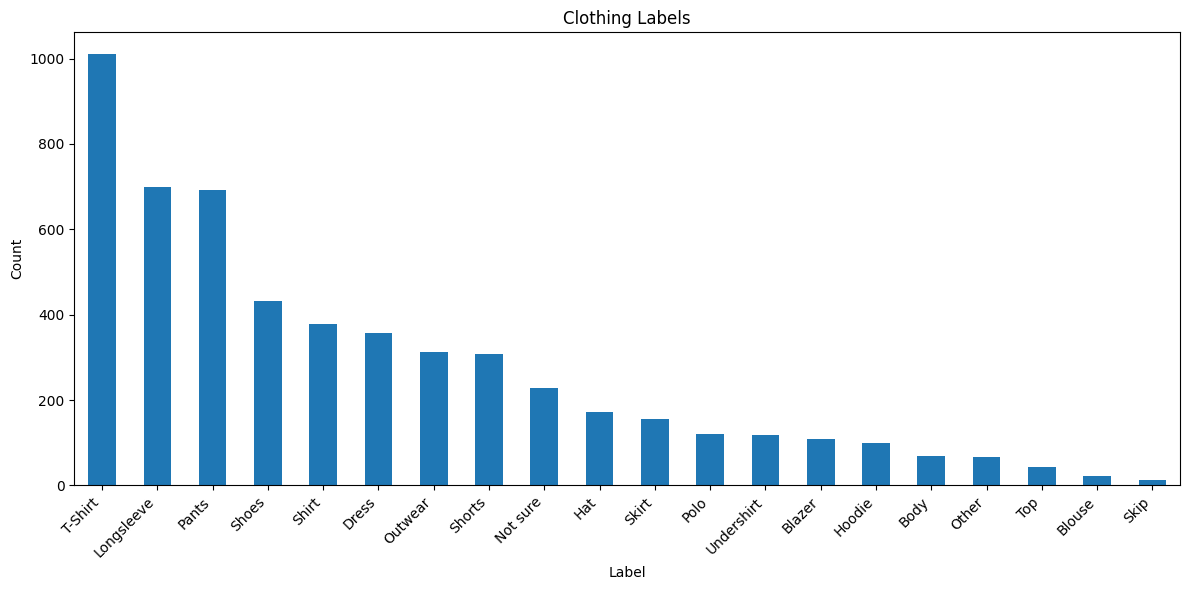

In [27]:
plt.figure(figsize=(12, 6))
df['label'].value_counts().head(20).plot(kind='bar')
plt.title('Clothing Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
df_no_kids = df[df['kids'] == False]
df_cleaned = df_no_kids.drop('kids', axis=1)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

Original dataset shape: (5403, 4)
Cleaned dataset shape: (4927, 3)


In [32]:
df = df_cleaned
df

,image,sender_id,label
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes
...,...,...,...
5396,9bdac063-6c07-4bfc-a04a-e45224c503df,204,Undershirt
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes


In [33]:
category_mapping = {
    'T-Shirt': 'T-Shirt',
    'Shoes': 'Shoes',
    'Top': 'Tops',
    'Blouse': 'Tops',
    'Shirt': 'Tops',
    'Polo': 'Tops',
    'Longsleeve': 'Tops',
    'Pants': 'Pants',
    'Jeans': 'Jeans',
    'Shorts': 'Shorts',
    'Skirt': 'Skirts',
    'Dress': 'Skirts',
    'Footwear': 'Shoes',
    'Outwear': 'Tops',
    'Hat': 'Tops',
    'Undershirt': 'T-Shirt',
    'Body': 'Tops',
    'Hoodie': 'Tops',
    'Blazer': 'Tops'
}

df_cleaned['merged_category'] = df_cleaned['label'].map(category_mapping).fillna('Other')

# Print the unique categories after merging
print("Unique categories after merging:")
print(df_cleaned['merged_category'].unique())

Unique categories after merging:
['Other' 'T-Shirt' 'Shoes' 'Shorts' 'Tops' 'Pants' 'Skirts']


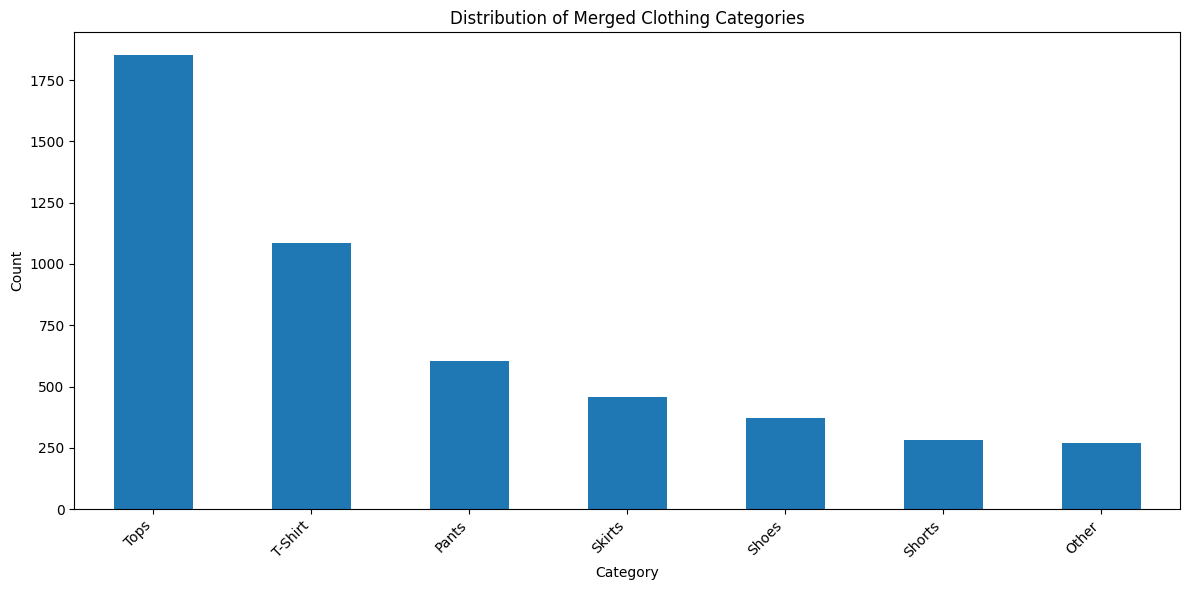

In [34]:
plt.figure(figsize=(12, 6))
df_cleaned['merged_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Merged Clothing Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
def balance_category(group):
    if len(group) > 500:
        return group.sample(n=500, random_state=42)
    return group


df_balanced = df_cleaned.groupby('merged_category').apply(balance_category).reset_index(drop=True)

# Print the count of each category in the balanced dataset
print("\nCategory counts in the balanced dataset:")
print(df_balanced['merged_category'].value_counts())


Category counts in the balanced dataset:
merged_category
Pants      500
T-Shirt    500
Tops       500
Skirts     457
Shoes      371
Shorts     284
Other      271
Name: count, dtype: int64


/tmp/ipykernel_3243603/3748658876.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_cleaned.groupby('merged_category').apply(balance_category).reset_index(drop=True)


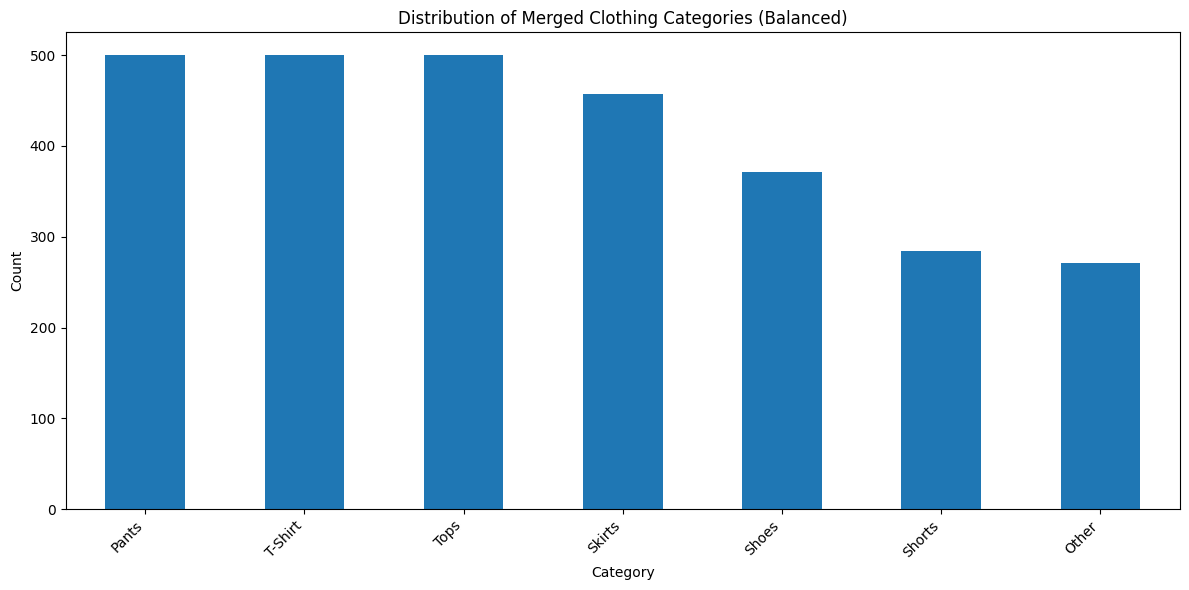

Balanced dataset shape: (2883, 4)
merged_category
Pants      500
T-Shirt    500
Tops       500
Skirts     457
Shoes      371
Shorts     284
Other      271
Name: count, dtype: int64


In [37]:
# Plot the distribution of the balanced dataset
plt.figure(figsize=(12, 6))
df_balanced['merged_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Merged Clothing Categories (Balanced)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Balanced dataset shape: {df_balanced.shape}")
print(df_balanced['merged_category'].value_counts())

In [ ]:
# Save the balanced dataset
df_balanced.to_csv('balanced_dataset.csv', index=False)

### Removing Corrupt Images

### Labelling these images

In [126]:
model = MllamaForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16, token=hf_token)
processor = MllamaProcessor.from_pretrained(model_name, token=hf_token)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [726]:
#!ls {IMAGES}

In [707]:
image_path = f"{IMAGES}/fac591c6-d884-44bf-9f73-3f9dd8e39c0a.jpg"

In [708]:
def get_image(image_path):
    with open(image_path, "rb") as f:
        return PIL_Image.open(f).convert("RGB")

image = get_image(image_path)

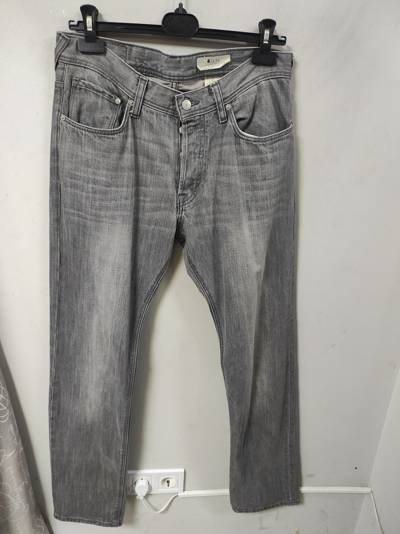

In [709]:
image

In [710]:
USER_TEXT = """
You are an expert fashion captioner, we are writing descriptions of clothes, look at the image closely and write a caption for it.

Write the following Title, Size, Category, Gender, Type, Description in JSON FORMAT, PLEASE DO NOT FORGET JSON, I WILL BE VERY SAD AND CRY

ALSO START WITH THE JSON AND NOT ANY THING ELSE, FIRST CHAR IN YOUR RESPONSE IS ITS OPENING BRACE, I WILL DRINK CHAI IF YOU FOLLOW THIS

FOLLOW THESE STEPS CLOSELY WHEN WRITING THE CAPTION: 
1. Only start your response with a dictionary like the example below, nothing else, I NEED TO PARSE IT LATER, SO DONT ADD ANYTHING ELSE-IT WILL BREAK MY CODE AND I WILL BE VERY SAD 
Remember-DO NOT SAY ANYTHING ELSE ABOUT WHAT IS GOING ON, just the opening brace is the first thing in your response nothing else ok?
2. REMEMBER TO CLOSE THE DICTIONARY WITH '}'BRACE, IT GOES AFTER THE END OF DESCRIPTION-YOU ALWAYS FORGET IT, THIS WILL CAUSE A FIRE ON A PRODUCTION SERVER BEING USE BY MILLIONS
3. If you cant tell the size from image, guess it! its okay but dont literally write that you guessed it
4. Do not make the caption very literal, all of these are product photos, DO NOT CAPTION HOW OR WHERE THEY ARE PLACED, FOCUS ON WRITING ABOUT THE PIECE OF CLOTHING
5. BE CREATIVE WITH THE DESCRIPTION BUT FOLLOW EVERYTHING CLOSELY FOR STRUCTURE
6. Return your answer in dictionary format, see the example below
7. Please do NOT add new lines or tabs in the JSON
8. I REPEAT DO NOT GIVE ME YOUR EXPLAINATION START WITH THE JSON

{"Title": "Title of item of clothing", "Size": {'S', 'M', 'L', 'XL'}, #select one randomly if you cant tell from the image. DO NOT TELL ME YOU ESTIMATE OR GUESSED IT ONLY THE LETTER IS ENOUGH", Category":  {T-Shirt, Shoes, Tops, Pants, Jeans, Shorts, Skirts, Shoes, Footwear}, "Gender": {M, F, U}, "Type": {Casual, Formal, Work Casual, Lounge}, "Description": "Write it here"}

Example: ALWAYS RETURN ANSWERS IN THE DICTIONARY FORMAT BELOW OK?

{"Title": "Casual White pant with logo on it", "size": "L", "Category": "Jeans", "Gender": "U", "Type": "Work Casual", "Description": "Write it here, this is where your stuff goes"} 
"""

In [711]:
USER_TEXT_OPTION_2 = """
You are an expert fashion captioner, we are writing descriptions of clothes, look at the image closely and write a caption for it.

Write the following Title, Size, Category, Gender, Type, Description in JSON FORMAT, PLEASE DO NOT FORGET JSON,

ALSO START WITH THE JSON AND NOT ANY THING ELSE, FIRST CHAR IN YOUR RESPONSE IS ITS OPENING BRACE

FOLLOW THESE STEPS CLOSELY WHEN WRITING THE CAPTION: 
1. Only start your response with a dictionary like the example below, nothing else, I NEED TO PARSE IT LATER, SO DONT ADD ANYTHING ELSE-IT WILL BREAK MY CODE
Remember-DO NOT SAY ANYTHING ELSE ABOUT WHAT IS GOING ON, just the opening brace is the first thing in your response nothing else ok?
2. REMEMBER TO CLOSE THE DICTIONARY WITH '}'BRACE, IT GOES AFTER THE END OF DESCRIPTION-YOU ALWAYS FORGET IT, THIS WILL CAUSE A LOT OF ISSUES
3. If you cant tell the size from image, guess it! its okay but dont literally write that you guessed it
4. Do not make the caption very literal, all of these are product photos, DO NOT CAPTION HOW OR WHERE THEY ARE PLACED, FOCUS ON WRITING ABOUT THE PIECE OF CLOTHING
5. BE CREATIVE WITH THE DESCRIPTION BUT FOLLOW EVERYTHING CLOSELY FOR STRUCTURE
6. Return your answer in dictionary format, see the example below

{"Title": "Title of item of clothing", "Size": {'S', 'M', 'L', 'XL'}, #select one randomly if you cant tell from the image. DO NOT TELL ME YOU ESTIMATE OR GUESSED IT ONLY THE LETTER IS ENOUGH", Category":  {T-Shirt, Shoes, Tops, Pants, Jeans, Shorts, Skirts, Shoes, Footwear}, "Gender": {M, F, U}, "Type": {Casual, Formal, Work Casual, Lounge}, "Description": "Write it here"}

Example: ALWAYS RETURN ANSWERS IN THE DICTIONARY FORMAT BELOW OK?

{"Title": "Casual White pant with logo on it", "size": "L", "Category": "Jeans", "Gender": "U", "Type": "Work Casual", "Description": "Write it here, this is where your stuff goes"} 
"""

In [712]:
conversation = [
        {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": USER_TEXT}]}
    ]
prompt = processor.apply_chat_template(conversation, add_special_tokens=False, add_generation_prompt=True, tokenize=False)
inputs = processor(prompt, image, return_tensors="pt").to(model.device)
output = model.generate(**inputs, temperature=1, top_p=0.9, max_new_tokens=512)
processor.decode(output[0])[len(prompt):]

'end_header_id|>\n\n{\n    "Title": "Grey Jeans",\n    "Size": "M",\n    "Category": "Jeans",\n    "Gender": "M",\n    "Type": "Casual",\n    "Description": "These grey jeans are a stylish and versatile choice for everyday wear. They feature a classic five-pocket design and a straight-leg silhouette, making them perfect for both casual and dressy occasions. The grey color is neutral and timeless, allowing you to pair them with a variety of tops and shoes. The jeans are made from a comfortable and durable fabric, ensuring they can withstand daily wear and tear. Overall, these grey jeans are a great addition to any wardrobe, offering both style and practicality."\n}<|eot_id|>'

In [713]:
print(processor.decode(output[0])[len(prompt):])

end_header_id|>

{
    "Title": "Grey Jeans",
    "Size": "M",
    "Category": "Jeans",
    "Gender": "M",
    "Type": "Casual",
    "Description": "These grey jeans are a stylish and versatile choice for everyday wear. They feature a classic five-pocket design and a straight-leg silhouette, making them perfect for both casual and dressy occasions. The grey color is neutral and timeless, allowing you to pair them with a variety of tops and shoes. The jeans are made from a comfortable and durable fabric, ensuring they can withstand daily wear and tear. Overall, these grey jeans are a great addition to any wardrobe, offering both style and practicality."
}<|eot_id|>


In [714]:
a = processor.decode(output[0])[len(prompt):]

In [715]:
a

'end_header_id|>\n\n{\n    "Title": "Grey Jeans",\n    "Size": "M",\n    "Category": "Jeans",\n    "Gender": "M",\n    "Type": "Casual",\n    "Description": "These grey jeans are a stylish and versatile choice for everyday wear. They feature a classic five-pocket design and a straight-leg silhouette, making them perfect for both casual and dressy occasions. The grey color is neutral and timeless, allowing you to pair them with a variety of tops and shoes. The jeans are made from a comfortable and durable fabric, ensuring they can withstand daily wear and tear. Overall, these grey jeans are a great addition to any wardrobe, offering both style and practicality."\n}<|eot_id|>'

In [716]:
IMAGES

'./DATA/images_compressed/'

In [717]:
import os
from PIL import Image as PIL_Image
import torch
from transformers import MllamaForConditionalGeneration, MllamaProcessor
from tqdm import tqdm

hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16, token=hf_token)
processor = MllamaProcessor.from_pretrained(model_name, token=hf_token)

# Define the input folder path
input_folder_path = IMAGES

# Define the output CSV file path
output_csv_file_path = "./captions.csv"

# Create an empty list to store the results
results = []

# Loop through the first 50 files in the input folder
for filename in tqdm(os.listdir(input_folder_path)[:50], desc="Processing files"):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Get the image path
        image_path = os.path.join(input_folder_path, filename)

        # Load the image
        image = get_image(image_path)

        # Create a conversation
        conversation = [
            {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": USER_TEXT}]}
        ]

        # Apply chat template and tokenize
        prompt = processor.apply_chat_template(conversation, add_special_tokens=False, add_generation_prompt=True, tokenize=False)
        inputs = processor(prompt, image, return_tensors="pt").to(model.device)

        # Generate the output
        output = model.generate(**inputs, temperature=1, top_p=0.9, max_new_tokens=512)

        # Decode the output
        decoded_output = processor.decode(output[0])[len(prompt):]

        # Append the result to the list
        results.append((filename, decoded_output))

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:54<00:00,  5.89s/it]


NameError: name 'csv' is not defined

In [719]:
import csv
# Write the results to a CSV file
with open(output_csv_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "description"])
    for result in results:
        writer.writerow(result)

In [720]:
df = pd.read_csv("./captions.csv")
df.describe()

,filename,description
count,50,50
unique,50,50
top,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,"end_header_id|>\n\nThe image features a white,..."
freq,1,1


In [734]:
def get_image(image_path):
    try:
        with open(image_path, "rb") as f:
            return PIL_Image.open(f).convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping corrupt image {image_path}")
        return None

In [741]:
import os
from PIL import Image as PIL_Image
import torch
from transformers import MllamaForConditionalGeneration, MllamaProcessor
from tqdm import tqdm

hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(model_name, device_map="cuda:7", torch_dtype=torch.bfloat16, token=hf_token)
processor = MllamaProcessor.from_pretrained(model_name, token=hf_token)

# Define the input folder path
input_folder_path = IMAGES

# Define the output CSV file path
output_csv_file_path = "./second_p2_360_to_500.csv"
# Create an empty list to store the results
results = []

# Loop through the first 50 files in the input folder
for filename in tqdm(os.listdir(input_folder_path)[361:500], desc="Processing files"):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        image_path = os.path.join(input_folder_path, filename)
        image = get_image(image_path)
        if image is not None:
            conversation = [
                {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": USER_TEXT}]}
            ]
            prompt = processor.apply_chat_template(conversation, add_special_tokens=False, add_generation_prompt=True, tokenize=False)
            inputs = processor(prompt, image, return_tensors="pt").to(model.device)
            output = model.generate(**inputs, temperature=1, top_p=0.9, max_new_tokens=512)
            decoded_output = processor.decode(output[0])[len(prompt):]
            results.append((filename, decoded_output))

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [06:58<00:00,  3.01s/it]


In [742]:
import csv
# Write the results to a CSV file
with open(output_csv_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "description"])
    for result in results:
        writer.writerow(result)